1. Consider the boundary value problem:
$$
-u'' = e^{sin(x)},\  \ u(0) = 0,\  \ u(1) = 0
$$

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [5]:
def thomas_tridiag(a, d, c, b):
    a = np.array(a, dtype=float).copy()
    d = np.array(d, dtype=float).copy()
    c = np.array(c, dtype=float).copy()
    b = np.array(b, dtype=float).copy()
    n = d.size
    for i in range(1, n):
        w = a[i-1] / d[i-1]
        d[i] -= w * c[i-1]
        b[i] -= w * b[i-1]
    x = np.empty(n)
    x[-1] = b[-1] / d[-1]
    for i in range(n-2, -1, -1):
        x[i] = (b[i] - c[i] * x[i+1]) / d[i]
    return x

def solve_poisson(n):
    h = 1.0 / n
    x = np.linspace(0.0, 1.0, n + 1)
    f = np.exp(np.sin(x[1:-1]))
    a = -np.ones(n-2) / h**2
    d =  2.0*np.ones(n-1) / h**2
    c = -np.ones(n-2) / h**2
    u_int = thomas_tridiag(a, d, c, f)
    u = np.zeros(n+1)
    u[1:-1] = u_int
    return x, u

def energy_seminorm(u, h):
    return (1.0/h)*float(np.sum(np.diff(u)**2))

def residual_inf(u, n):
    h = 1.0/n
    x = np.linspace(0.0, 1.0, n+1)
    f = np.exp(np.sin(x[1:-1]))
    u_int = u[1:-1]
    Au = (2*u_int - u[2:] - u[:-2]) / h**2
    r = f - Au
    return float(np.max(np.abs(r)))

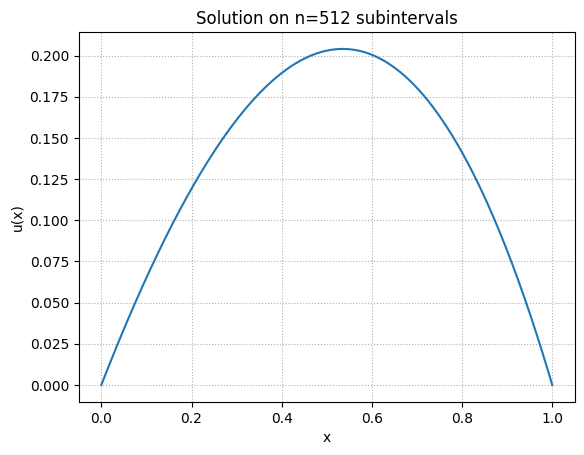

In [6]:
n = 512
x, u = solve_poisson(n)

plt.figure()
plt.plot(x, u)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Solution on n={n} subintervals")
plt.grid(True, which='both', ls=':')
plt.show()

,n (fine),h (fine),||u_h - u_{2h}||_inf,p_obs from prev,residual_inf (fine),energy (fine)
0,32,0.031250,1.286822e-05,NaN,5.484502e-14,0.222623
1,64,0.015625,3.231188e-06,1.993676,2.426948e-13,0.222800
2,128,0.007812,8.074116e-07,2.000688,1.237233e-12,0.222844
3,256,0.003906,2.018288e-07,2.000172,3.856915e-12,0.222855
4,512,0.001953,5.045571e-08,2.000043,1.774980e-11,0.222858
5,1024,0.000977,1.261387e-08,2.000007,7.522560e-11,0.222858
6,2048,0.000488,3.153609e-09,1.999935,3.043612e-10,0.222859


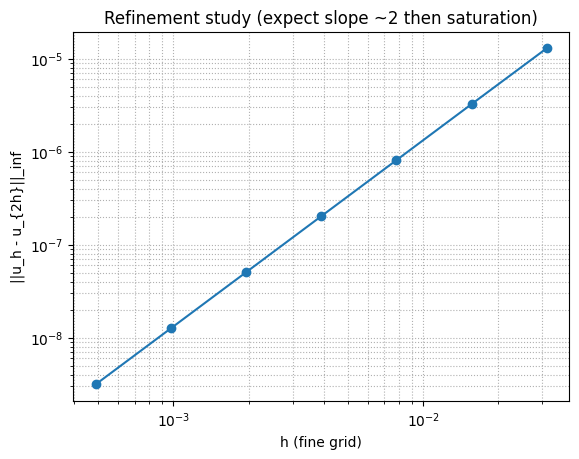

Last observed order p ≈ 2.000
Minimum inter-grid error ≈ 3.154e-09 at h ≈ 4.883e-04
||u||_inf (n=512) ≈ 0.204021, bound (1/8)||f||_inf ≈ 0.289972


In [7]:
levels = 8
N0 = 16
sols = []
for k in range(levels):
    n_k = N0*(2**k)
    xk, uk = solve_poisson(n_k)
    sols.append((n_k, xk, uk))

rows = []
errs = []
hs = []
for k in range(1, levels):
    n_c, x_c, u_c = sols[k-1]
    n_f, x_f, u_f = sols[k]
    h_f = 1.0 / n_f
    err = float(np.max(np.abs(u_f[::2] - u_c)))
    errs.append(err)
    hs.append(h_f)
    p_obs = None
    if k >= 2 and errs[-2] > 0 and err > 0:
        p_obs = math.log(errs[-2]/err, 2.0)
    res = residual_inf(u_f, n_f)
    en  = energy_seminorm(u_f, h_f)
    rows.append({"n (fine)": n_f, "h (fine)": h_f, "||u_h - u_{2h}||_inf": err,
                 "p_obs from prev": p_obs, "residual_inf (fine)": res, "energy (fine)": en})

df = pd.DataFrame(rows)
display(df)

plt.figure()
plt.loglog(hs, errs, marker='o')
plt.xlabel("h (fine grid)")
plt.ylabel("||u_h - u_{2h}||_inf")
plt.title("Refinement study (expect slope ~2 then saturation)")
plt.grid(True, which='both', ls=':')
plt.show()

if len(errs) >= 2 and errs[-1] > 0 and errs[-2] > 0:
    p_last = math.log(errs[-2]/errs[-1], 2.0)
else:
    p_last = None
min_err = float(np.min(errs)) if len(errs) else float("nan")
h_at_min = hs[int(np.argmin(errs))] if len(errs) else float("nan")
u_inf = float(np.max(np.abs(u)))
f_inf = float(np.max(np.exp(np.sin(x))))
bound = 0.125 * f_inf

print(f"Last observed order p ≈ {p_last:.3f}" if p_last is not None else "p_last N/A")
print(f"Minimum inter-grid error ≈ {min_err:.3e} at h ≈ {h_at_min:.3e}")
print(f"||u||_inf (n={n}) ≈ {u_inf:.6f}, bound (1/8)||f||_inf ≈ {bound:.6f}")

#### (1) Grid-Refinement (Inter-Grid Comparison)

For two consecutive grid levels \(h\) and \(h/2\), both solved by the same
finite-difference scheme, the difference
\[
E(h) = \|u^{(h)} - u^{(h/2)}\|_\infty
\]
serves as a *surrogate error measure*.
If the method is second-order accurate, then
\[
E(h) \approx C h^2 \quad \Rightarrow \quad 
p_{\text{obs}} = \log_2\!\frac{E(2h)}{E(h)} \approx 2.
\]
Observing this second-order slope confirms that both the discretization and
implementation are correct — **no exact solution is required.**

---

#### (2) Energy and Maximum-Principle Consistency

The discrete energy identity
\[
(Au,u)_h = \frac{1}{h}\sum_j (u_{j+1}-u_j)^2 \ge 0
\]
and the theoretical bound
\[
\|u\|_\infty \le \tfrac18 \|f\|_\infty
\]
are checked.  
If both hold numerically, the computed solution behaves physically correctly:
it is smooth, concave upward, and satisfies the Dirichlet boundaries.

---

#### Exploring the Limitation of Accuracy

Even though the finite-difference scheme is formally second-order, the total numerical error does not decrease indefinitely when refining the grid.
It consists of two competing components:
\[
E(h) \approx C_1 h^2 
\quad + \quad C_2\, \varepsilon\, h^{-2},
\]
where:
- \(C_1 h^2\): **truncation error**, decreasing with smaller \(h\);
- \(C_2 \varepsilon h^{-2}\): **round-off error**, amplified by the condition number
  \(\kappa(A) \sim O(h^{-2})\) of the tridiagonal Poisson matrix;
- \(\varepsilon\): machine precision (≈ 2.2×10⁻¹⁶ for double precision).

Minimizing \(E(h)\) with respect to \(h\) gives the **optimal step size**
\[
h_{\text{opt}} \sim (\varepsilon)^{1/4} \approx 10^{-4},
\]
and the **smallest achievable total error**
\[
E_{\min} \sim O(\varepsilon^{1/2}) \approx 10^{-8}\!-\!10^{-9}.
\]